This is the same script as DMML2_project_pepper_hyperparameters.ipynb but to be run locally or in colab, for colab when runtime is changed to gpu run \
!git clone https://github.com/MilianAlba/DMML2_CA.git \
if you don't have it already, make sure the DMML2_CA folder is available in the files tab

In [1]:
!pip install -q -U keras-tuner

--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/console.py", line 1673, in print
    extend(render(renderable, render_options))
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/console.py", line 1305, in render
    for render_output in iter_render:
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/utils/logging.py", line 134, in __rich_console__
    for line in lines:
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/segment.py", line 249, in split_lines
    for segment in segments:
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/console.py", line 1283, in render
    renderable = rich_cast(renderable)
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/protocol.py", line 36

In [2]:
import pandas as pd
import os
import cv2
import numpy as np
from re import sub
import tensorflow as tf
from tensorflow import keras
from keras import metrics

import matplotlib.colors as mcolors
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense


from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras.preprocessing import image
from tensorboard.plugins.hparams import api as hp
import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras import preprocessing
import keras_tuner as kt
print("Done importing packages!")

Done importing packages!


In [3]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [4]:

data_dir = "plantville"
train_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.28,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "training",
                                             image_size=IMG_SIZE)

### two validation subsets, one is actually the sample subset to be used to tune the parameters
validation_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.08,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "validation",
                                             image_size=IMG_SIZE)


test_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.2,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "validation",
                                             image_size=IMG_SIZE)

print(train_dataset)


Found 20105 files belonging to 13 classes.
Using 14476 files for training.
Found 20105 files belonging to 13 classes.
Using 1608 files for validation.
Found 20105 files belonging to 13 classes.
Using 4021 files for validation.
<BatchDataset element_spec=(TensorSpec(shape=(None, 240, 240, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 13), dtype=tf.float32, name=None))>


In [5]:
class_names = validation_dataset.class_names
num_classes = len(class_names)
for i in range(1, num_classes + 1):
    print(str(i) + ". ", class_names[i - 1])

1.  Apple___Apple_scab
2.  Apple___Cedar_apple_rust
3.  Apple___healthy
4.  Pepper__bell___Bacterial_spot
5.  Pepper__bell___healthy
6.  Tomato___Bacterial_spot
7.  Tomato___Early_blight
8.  Tomato___Late_blight
9.  Tomato___Leaf_Mold
10.  Tomato___Septoria_leaf_spot
11.  Tomato___Tomato_Yellow_Leaf_Curl_Virus
12.  Tomato___Tomato_mosaic_virus
13.  Tomato___healthy


In [6]:
print('Number of batches used to tune the parameters: %d' % tf.data.experimental.cardinality(validation_dataset))

Number of batches used to tune the parameters: 51


In [7]:
AUTOTUNE = tf.data.AUTOTUNE
print(AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

-1


In [8]:
IMG_SHAPE = IMG_SIZE + (3,)

In [9]:
preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input

In [10]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


219055592/219055592 [==============================] - 5s 0us/step


In [12]:
image_batch, label_batch = next(iter(validation_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1536)


In [13]:
base_model.trainable = False

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

print(feature_batch_average.shape)

(32, 1536)


In [15]:
prediction_layer = tf.keras.layers.Dense(num_classes, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 13)


In [17]:
def model_builder(hp):
  inputs = tf.keras.Input(shape=(240, 240, 3))
  #x = data_augmentation(inputs)
  x = preprocess_input(inputs)
  x = base_model(x, training=False)
  x = global_average_layer(x)
  hp_drop = hp.Choice('drop', values=[0.1, 0.2])
  x = tf.keras.layers.Dropout(hp_drop)(x)
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
# change the categorical crossentropy from logits to False, as the activation is softmax
  model.compile(optimizer=keras.optimizers.Adagrad(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])

  return model

In [18]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=6,
                     factor=2,
                     overwrite=True,
                     directory='hyper_tuner',
                     project_name='HPMobileNetAdagrad')

In [23]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [19]:
#tuner.search(train_dataset, epochs=1, validation_data=validation_dataset, callbacks=[stop_early])
tuner.search(train_dataset, epochs=1, validation_data=validation_dataset)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal learning rate for the optimizer
is {best_hps.get('learning_rate', 'drop')}.
""")

Trial 4 Complete [00h 08m 52s]
val_accuracy: 0.8691867589950562

Best val_accuracy So Far: 0.9358368515968323
Total elapsed time: 00h 32m 10s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
0.1               |0.1               |drop
1e-05             |0.001             |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
453/453 [==============================] - 238s 499ms/step - loss: 0.3371 - accuracy: 0.9107 - val_loss: 0.3451 - val_accuracy: 0.9117
Epoch 2/2
453/453 [==============================] - ETA: 0s - loss: 0.2285 - accuracy: 0.9347

2022-08-05 13:17:56.141655: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at save_restore_v2_ops.cc:138 : RESOURCE_EXHAUSTED: DMML2_CA/hyper_tuner/tuner1attempt/trial_0004/checkpoint_temp/part-00000-of-00001.data-00000-of-00001.tempstate3114052291438802082; Disk quota exceeded


ResourceExhaustedError: DMML2_CA/hyper_tuner/tuner1attempt/trial_0004/checkpoint_temp/part-00000-of-00001.data-00000-of-00001.tempstate3114052291438802082; Disk quota exceeded [Op:SaveV2]

In [ ]:
model = tuner.hypermodel.build(best_hps)

history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=validation_dataset)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/5
536/536 [==============================] - 171s 299ms/step - loss: 0.5644 - accuracy: 0.8248 - val_loss: 0.4663 - val_accuracy: 0.8557
Epoch 2/5
536/536 [==============================] - 157s 293ms/step - loss: 0.4504 - accuracy: 0.8573 - val_loss: 0.4108 - val_accuracy: 0.8698
Epoch 3/5
536/536 [==============================] - 159s 295ms/step - loss: 0.3947 - accuracy: 0.8753 - val_loss: 0.3559 - val_accuracy: 0.8870
Epoch 4/5
536/536 [==============================] - 157s 293ms/step - loss: 0.3647 - accuracy: 0.8836 - val_loss: 0.3342 - val_accuracy: 0.8925
Epoch 5/5
536/536 [==============================] - 156s 291ms/step - loss: 0.3383 - accuracy: 0.8929 - val_loss: 0.2970 - val_accuracy: 0.9078
Best epoch: 5


In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(train_dataset, epochs=best_epoch, validation_data=validation_dataset)

Epoch 1/5
536/536 [==============================] - 170s 298ms/step - loss: 0.3196 - accuracy: 0.8941 - val_loss: 0.2835 - val_accuracy: 0.9116
Epoch 2/5
536/536 [==============================] - 157s 292ms/step - loss: 0.3060 - accuracy: 0.8998 - val_loss: 0.2747 - val_accuracy: 0.9128
Epoch 3/5
536/536 [==============================] - 157s 292ms/step - loss: 0.2947 - accuracy: 0.9027 - val_loss: 0.2849 - val_accuracy: 0.9065
Epoch 4/5
536/536 [==============================] - 157s 292ms/step - loss: 0.2881 - accuracy: 0.9066 - val_loss: 0.2483 - val_accuracy: 0.9254
Epoch 5/5
536/536 [==============================] - 158s 294ms/step - loss: 0.2746 - accuracy: 0.9090 - val_loss: 0.2624 - val_accuracy: 0.9156


In [ ]:
eval_result = hypermodel.evaluate(validation_dataset)

print("[val loss, val accuracy]:", eval_result)

149/149 [==============================] - 35s 230ms/step - loss: 0.2624 - accuracy: 0.9156
[val loss, val accuracy]: [0.26243841648101807, 0.9155639410018921]


In [ ]:
base_learning_rate = best_hps.get('learning_rate')
model.compile(optimizer=tf.keras.optimizers.Adagrad(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 240, 240, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 240, 240, 3)      0         
 bda)                                                            
                                                                 
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                    

In [ ]:
len(model.trainable_variables)

2

In [25]:
initial_epochs = 10

In [ ]:
len(train_dataset)

536

In [26]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

NameError: ignored

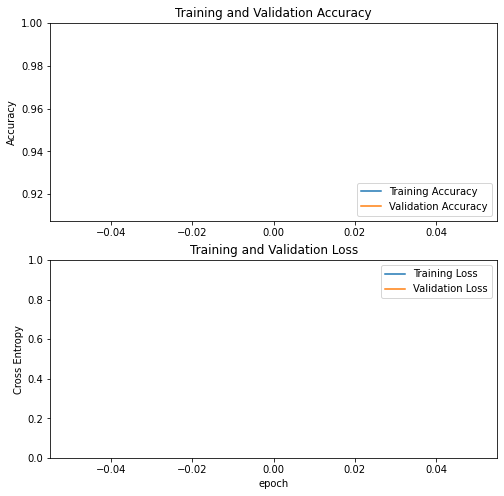

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

KeyError: ignored

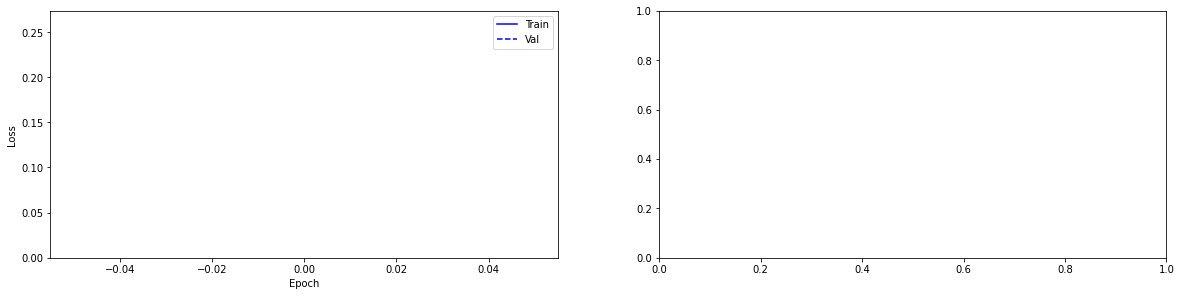

In [ ]:
plot_metrics(history)

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 700

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  780


In [ ]:
fine_tuning_learning_rate = 1e-5
model.compile(optimizer=tf.keras.optimizers.Adam(lr=fine_tuning_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 240, 240, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 240, 240, 3)      0         
 bda)                                                            
                                                                 
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                    

In [ ]:
len(model.trainable_variables)

52

In [ ]:
fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 1/16
536/536 [==============================] - 173s 322ms/step - loss: 0.1192 - accuracy: 0.9599 - val_loss: 0.1314 - val_accuracy: 0.9569
Epoch 2/16
536/536 [==============================] - 172s 321ms/step - loss: 0.0798 - accuracy: 0.9733 - val_loss: 0.1211 - val_accuracy: 0.9595
Epoch 3/16
536/536 [==============================] - 172s 321ms/step - loss: 0.0546 - accuracy: 0.9825 - val_loss: 0.1084 - val_accuracy: 0.9653
Epoch 4/16
536/536 [==============================] - 173s 321ms/step - loss: 0.0341 - accuracy: 0.9903 - val_loss: 0.1012 - val_accuracy: 0.9664
Epoch 5/16
 71/536 [==>...........................] - ETA: 1:59 - loss: 0.0269 - accuracy: 0.9912

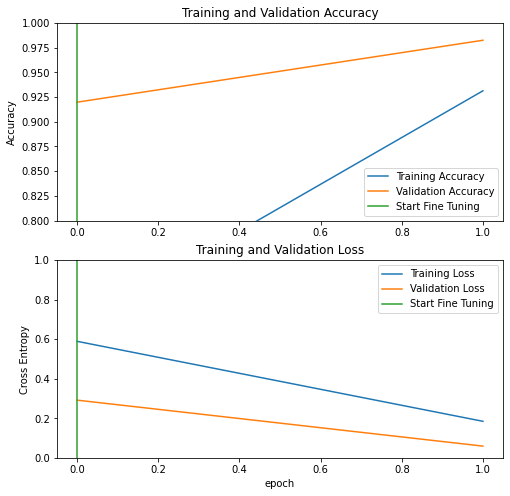

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']



plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy')
plt.show()

In [ ]:
def plot_metrics(history):
  colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
  metrics = ['loss', 'auc', 'precision', 'recall']
  plt.figure(figsize=(20,10))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

    METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.CategoricalAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc')
]

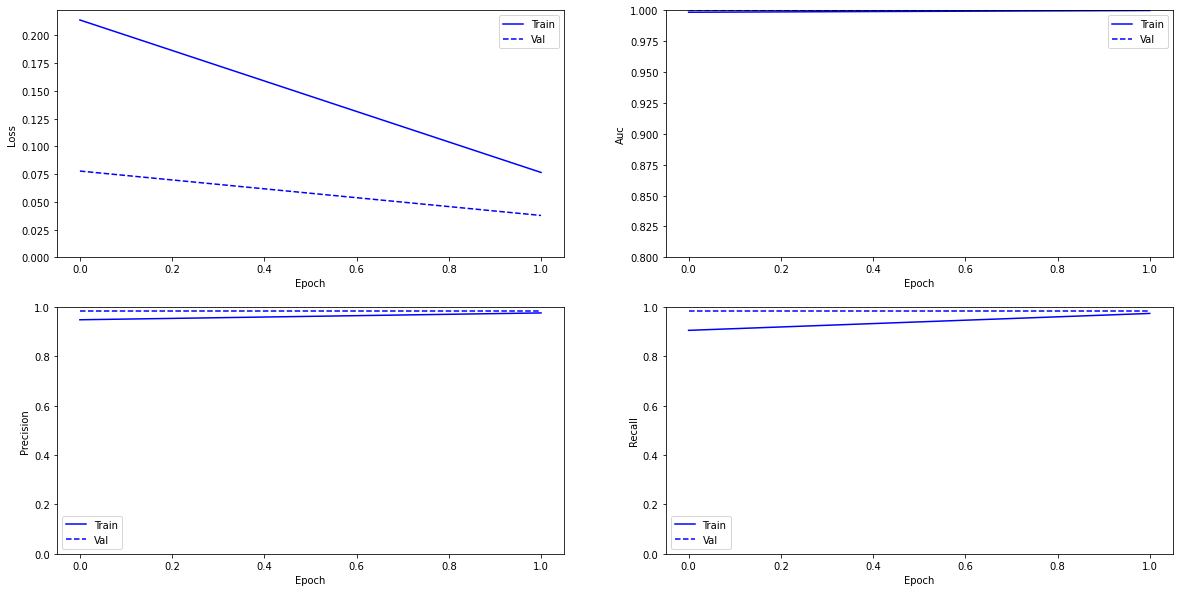

In [ ]:
plot_metrics(history_fine)

In [ ]:
result = model.evaluate(test_dataset)

3/3 [==============================] - 25s 8s/step - loss: 0.0594 - accuracy: 0.9896


In [ ]:
result = model.evaluate(test_dataset_outdoor)

1/1 [==============================] - 7s 7s/step - loss: 0.2310 - accuracy: 0.9412


In [ ]:
result = model.evaluate(validation_dataset)

13/13 [==============================] - 101s 8s/step - loss: 0.0576 - accuracy: 0.9850


In [ ]:
print(len(test_dataset))

3


In [ ]:
print(len(validation_dataset))

13


In [ ]:
print(len(train_dataset))

62


In [ ]:
metrics = ["loss", "tp", "fp", "tn", "fn", "accuracy", "precision", "recall", "auc"]
for i in range(len(result)):
    print("{} : {}".format(metrics[i],round(result[i], 3)))

loss : 0.035
tp : 288.0
fp : 5.0
tn : 3511.0
fn : 5.0
accuracy : 0.983
precision : 0.983
recall : 0.983
auc : 1.0


Predictions:
 [1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1]
Labels:
 [1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1]


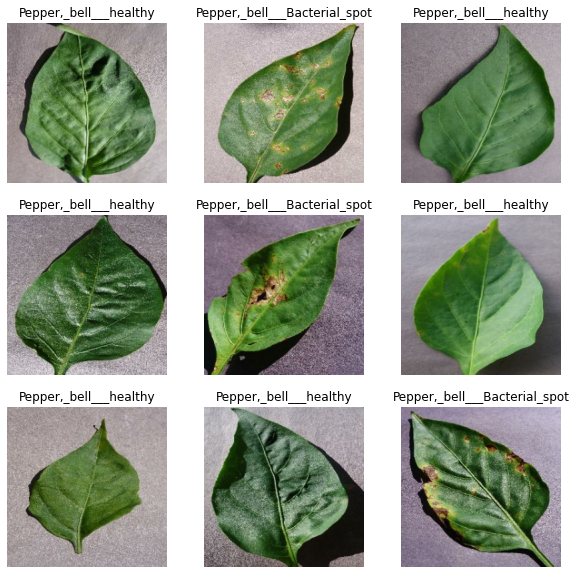

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

predictions = tf.nn.softmax(predictions)
predictions = list(np.argmax(x) for x in predictions.numpy())

print('Predictions:\n', predictions)
print('Labels:\n', list(np.argmax(x) for x in label_batch))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
models.save_model(model, "./HPMobileNetAdagrad_indoor")

INFO:tensorflow:Assets written to: ./inception_v3/assets


INFO:tensorflow:Assets written to: ./inception_v3/assets
